In [ ]:
import numpy as np
import cv2
import math
import os

import random

from matplotlib import pyplot as plt
from collections import deque
from google.colab import drive
from google.colab.patches import cv2_imshow

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Aufagbe 1

In [ ]:
# Bilder mit unterschiedlicher Belichtung einlesen
folder_path = '/content/drive/My Drive/Colab Notebooks/BV2/Testbilder/Vildkatten/'

vildkatten_list = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        vildkatten_list.append(img)

# Konvertiere die Liste in ein NumPy-Array
vildkatten_array = np.array(vildkatten_list)
vildkatten_image = vildkatten_list[1]

<ipython-input-3-499520af90e0>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vildkatten_array = np.array(vildkatten_list)


In [ ]:
imgGray = vildkatten_list[1]
vildkatten_list.pop(1)

array([[ 14,  11,   0, ...,  44,  39,  43],
       [ 10,   7,   0, ...,  41,  44,  46],
       [  7,   5,   0, ...,  42,  49,  52],
       ...,
       [141, 142, 141, ...,  79,  79,  78],
       [142, 143, 142, ...,  80,  78,  77],
       [143, 144, 142, ...,  83,  78,  75]], dtype=uint8)

In [ ]:
#cv2_imshow(temp_imgRes)
MIN_MATCH_COUNT = 10

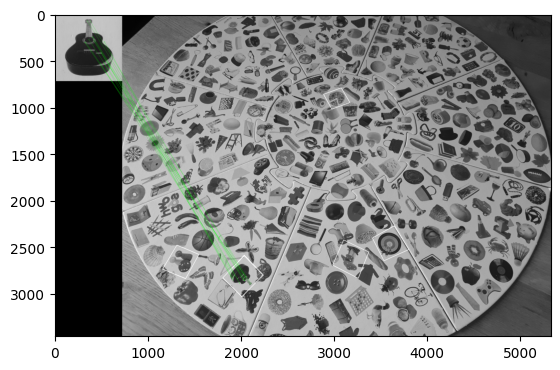

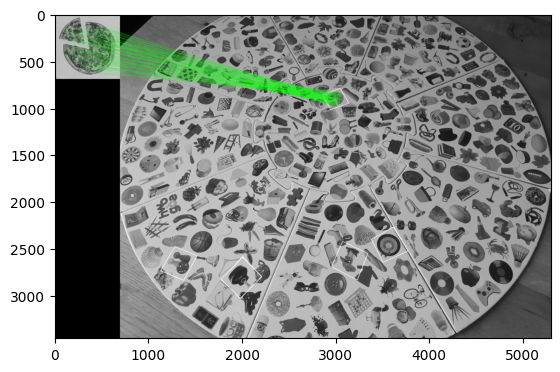

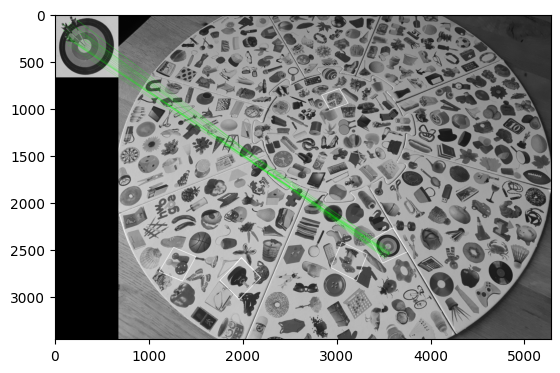

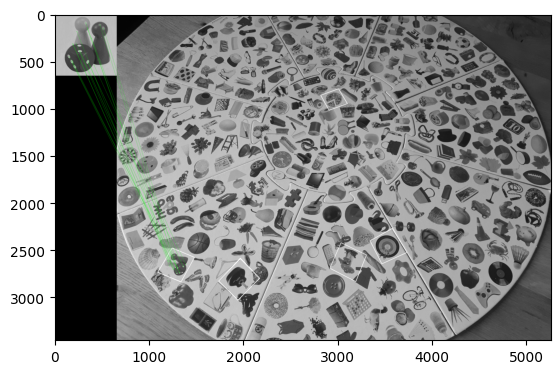

Not enough matches are found - 5/10


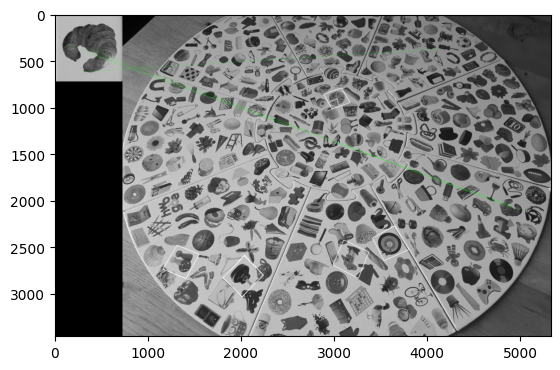

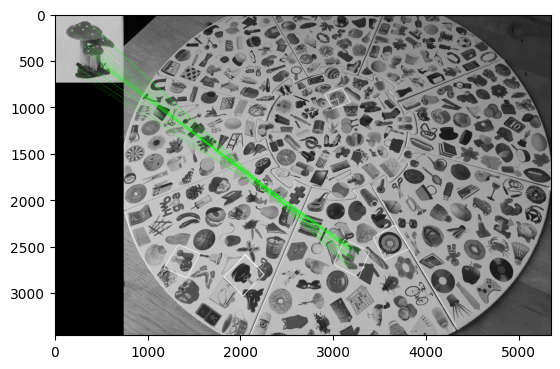

Not enough matches are found - 10/10


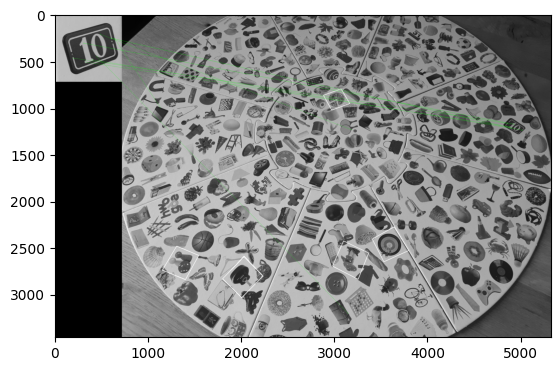

In [ ]:
for i in range(7):
    tempGray = vildkatten_list[i]
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(tempGray,None)
    kp2, des2 = sift.detectAndCompute(imgGray,None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = tempGray.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        img2 = cv2.polylines(imgGray,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                      singlePointColor = None,
                      matchesMask = matchesMask, # draw only inliers
                      flags = 2)
    img3 = cv2.drawMatches(tempGray,kp1,img2,kp2,good,None,**draw_params)
    plt.imshow(img3, 'gray'),plt.show()
    cv2.imwrite(f'/content/drive/My Drive/Colab Notebooks/BV2/sift_{i}.png', img3)

Aufgabe 2

In [ ]:
directory = '/content/drive/My Drive/Colab Notebooks/BV2/Testbilder/A_vs_B/A/'

included_extensions = ['jpg','jpeg','JPG']
fileNames = [fn for fn in os.listdir(directory)
              if any(fn.endswith(ext) for ext in included_extensions)]

for imgFile in fileNames:
    filePath = os.path.join(directory, imgFile)
    print(f"processing {imgFile} ...")
    imgCol = cv2.cvtColor(cv2.imread(filePath), cv2.COLOR_BGR2RGB)

    # Bild verkleinern
    sy, sx = imgCol.shape[:2]
    scaling_factor = 0.25
    syNew = int(sy * scaling_factor)
    sxNew = int(sx * scaling_factor)
    imgCol = cv2.resize(imgCol, (sxNew, syNew))

    # in HSV umwandeln und auf Basis des Sättigung schwellwerten
    imgHsv = cv2.cvtColor(imgCol, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(imgHsv)
    _, imgBin = cv2.threshold(s, 80, 255, cv2.THRESH_BINARY)

    # Rauschen durch morphologische Operatoren reduzieren
    kernel = np.ones((3, 3), np.uint8)
    imgBin = cv2.erode(imgBin, kernel, iterations=1)
    imgBin = cv2.erode(imgBin, kernel, iterations=1)
    imgBin = cv2.dilate(imgBin, kernel, iterations=1)
    imgBin = cv2.erode(imgBin, kernel, iterations=1)
    imgBin = cv2.erode(imgBin, kernel, iterations=1)
    imgBin = cv2.dilate(imgBin, kernel, iterations=1)

    cv2.imwrite(f'/content/drive/My Drive/Colab Notebooks/BV2/Testbilder/A_vs_B/A_Bin/{imgFile}', imgBin)

    #plt.imshow(imgBin, cmap="gray")
    #plt.show()

In [ ]:
#Äpfel
folder_path = '/content/drive/My Drive/Colab Notebooks/BV2/Testbilder/A_vs_B/A_Bin'

apple_list = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        apple_list.append(img)

# Konvertiere die Liste in ein NumPy-Array
apple_array = np.array(apple_list)
apple_image = apple_list[1]

<ipython-input-3-a3c07909fc92>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  apple_array = np.array(apple_list)


In [ ]:
#Birnen
folder_path = '/content/drive/My Drive/Colab Notebooks/BV2/Testbilder/A_vs_B/B_Bin'

pear_list = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        pear_list.append(img)

# Konvertiere die Liste in ein NumPy-Array
pear_array = np.array(pear_list)
pear_image = pear_list[1]

<ipython-input-4-678ea5b889f9>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pear_array = np.array(pear_list)


In [ ]:
circA = []
hueA = []
appleData = []

In [ ]:
circB = []
hueB = []
pearData = []

In [ ]:
#Zwei Eigenschaften

directory = '/content/drive/My Drive/Colab Notebooks/BV2/Testbilder/A_vs_B/A'

included_extensions = ['jpg','jpeg','JPG']
fileNames = [fn for fn in os.listdir(directory)
              if any(fn.endswith(ext) for ext in included_extensions)]

for imgFile in fileNames:
    filePath = os.path.join(directory, imgFile)
    print(f"processing {imgFile} ...")
    imgCol = cv2.cvtColor(cv2.imread(filePath), cv2.COLOR_BGR2RGB)

    # Bild verkleinern
    sy, sx = imgCol.shape[:2]
    scaling_factor = 0.25
    syNew = int(sy * scaling_factor)
    sxNew = int(sx * scaling_factor)
    imgCol = cv2.resize(imgCol, (sxNew, syNew))

    # in HSV umwandeln und auf Basis des Sättigung schwellwerten
    imgHsv = cv2.cvtColor(imgCol, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(imgHsv)
    _, imgBin = cv2.threshold(s, 80, 255, cv2.THRESH_BINARY)

    # Rauschen durch morphologische Operatoren reduzieren
    kernel = np.ones((3, 3), np.uint8)
    imgBin = cv2.erode(imgBin, kernel, iterations=1)
    imgBin = cv2.erode(imgBin, kernel, iterations=1)
    imgBin = cv2.dilate(imgBin, kernel, iterations=1)
    imgBin = cv2.erode(imgBin, kernel, iterations=1)
    imgBin = cv2.erode(imgBin, kernel, iterations=1)
    imgBin = cv2.dilate(imgBin, kernel, iterations=1)

    #plt.imshow(imgBin, cmap="gray")
    #plt.show()

    # Hier stellen wir sicher, dass es weniger Vordergrund- (weiße) als Hintergrund-Pixel (schwarze) gibt
    cntForegroundPixel = cv2.countNonZero(imgBin)
    cntBackgroundPixel = imgBin.size - cntForegroundPixel
    if cntBackgroundPixel < cntForegroundPixel:
        imgBin = cv2.bitwise_not(imgBin)

    # Konturen berechnen...
    contours, _ = cv2.findContours(imgBin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ... und längste davon bestimmen
    longestContour = None
    longestContourPerimeter = -1
    longestContourArea = -1

    for contour in contours:
        perimeter = cv2.arcLength(contour, closed=True)

        if perimeter > longestContourPerimeter:
            longestContour = contour
            longestContourPerimeter = perimeter
            longestContourArea = cv2.contourArea(contour)

    cv2.drawContours(imgCol, [longestContour], -1, (0,255,255), 4)

    #approxContour = cv2.approxPolyDP(longestContour, 0.005 * longestContourPerimeter, True)
    #cv2.drawContours(imgCol, [approxContour], -1, (255,0,255), 4)

    #plt.imshow(imgCol, cmap="gray")
    #plt.show()

    # Merkmal berechnen: Rundheit
    pCorr = 0.95 * longestContourPerimeter
    circularity = 4 * math.pi * longestContourArea / pCorr**2

    # Merkmal berechnen: Durchschnittlicher H-Wert
    mask = np.zeros_like(h)
    cv2.drawContours(mask, [longestContour], -1, 255, thickness=cv2.FILLED)
    pixelsInside_h = h[mask == 255]
    meanH = np.mean(pixelsInside_h)

    appleData.append([imgFile, circularity, meanH])


    print(f"{imgFile}: circ: {circularity}; hue: {meanH}")

processing img060.jpg ...
img060.jpg: circ: 0.9560676541646481; hue: 23.082323508717067
processing img057.jpg ...
img057.jpg: circ: 0.6055242899895069; hue: 161.8844426143595
processing img030.jpg ...
img030.jpg: circ: 0.856161667203952; hue: 38.803006847275974
processing img021.jpg ...
img021.jpg: circ: 0.880627618514556; hue: 17.74317208292878
processing img006.jpg ...
img006.jpg: circ: 0.9146783786278293; hue: 18.583831607602935
processing img009.jpg ...
img009.jpg: circ: 0.8816664794672331; hue: 48.77438694776156
processing img038.jpg ...
img038.jpg: circ: 0.45453018372953186; hue: 18.502318656088747
processing img023.jpg ...
img023.jpg: circ: 0.23651155072186447; hue: 27.51199084637747
processing img040.jpg ...
img040.jpg: circ: 0.915764940539867; hue: 31.442160686427457
processing img014.jpg ...
img014.jpg: circ: 0.9208955715424002; hue: 13.733844347766038
processing img024.jpg ...
img024.jpg: circ: 0.8146894219427145; hue: 8.180312459011615
processing img025.jpg ...
img025.jpg: 

In [ ]:
print(pearData)
print(appleData)

[['img001.jpg', 0.5857651444679045, 29.537345513164965], ['img008.jpg', 0.5693701060598694, 19.285675462435346], ['img009.jpg', 0.837773463521761, 27.643330945368675], ['img006.jpg', 0.7826162779444357, 27.186091427353617], ['img014.jpg', 0.7285041296245836, 25.778972801325416], ['img013.jpg', 0.739422228572895, 24.764972856225555], ['img022.jpg', 0.22036347652352767, 42.59087104959018], ['img019.jpg', 0.5962637202416773, 22.530622433481465], ['img016.jpg', 0.7117280353009109, 27.43438932058179], ['img002.jpg', 0.8609090784332968, 33.56822953114066], ['img018.jpg', 0.4180957760681406, 24.638857384382376], ['img015.jpg', 0.49336164952547124, 28.21462879099767], ['img004.jpg', 0.8181746655886761, 23.18075422626788], ['img027.jpg', 0.7229514478818315, 25.07884040062435], ['img023.jpg', 0.5735366414967348, 27.24678309795599], ['img012.jpg', 0.7235996716088877, 14.598698376833426], ['img007.jpg', 0.6009603574065122, 28.49769429760432], ['img017.jpg', 0.7493243825090965, 22.38549688476482], 

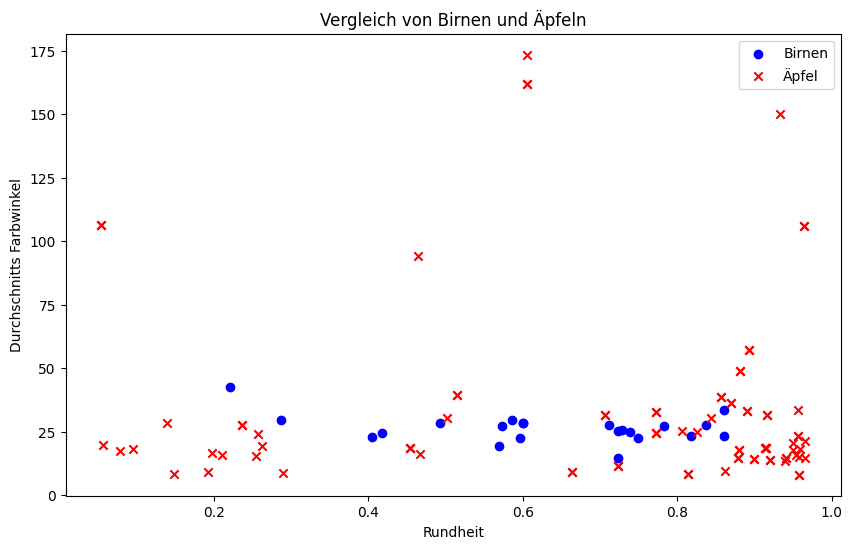

In [ ]:
# Ihre Datenarrays (Beispielwerte)
data1 = [['img001.jpg', 0.585, 29.537], ['img002.jpg', 0.569, 19.285], ...]
data2 = [['img003.jpg', 0.670, 35.123], ['img004.jpg', 0.560, 22.345], ...]

# Extrahieren der numerischen Werte aus den Arrays
x_values1 = [item[1] for item in pearData]
y_values1 = [item[2] for item in pearData]

x_values2 = [item[1] for item in appleData]
y_values2 = [item[2] for item in appleData]

# Erstellen des Plots
plt.figure(figsize=(10, 6))

# Zeichnen der Datenreihen mit unterschiedlichen Symbolen
plt.scatter(x_values1, y_values1, marker='o', color='blue', label='Birnen')
plt.scatter(x_values2, y_values2, marker='x', color='red', label='Äpfel')

# Hinzufügen von Titel und Achsenbeschriftungen
plt.title('Vergleich von Birnen und Äpfeln')
plt.xlabel('Rundheit')
plt.ylabel('Durchschnitts Farbwinkel')

# Hinzufügen einer Legende
plt.legend()

plt.savefig('/content/drive/My Drive/Colab Notebooks/BV2/diagramm.png', dpi=300)

# Anzeigen des Diagramms
plt.show()
